In [6]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order +1):
        features.update({
            f'sin_{freq}_{i}':np.sin(i*k),
            f'cos_{freq}_{i}':np.cos(i*k),
        })
    return pd.DataFrame(features, index=index)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

C:\Users\zonn\AppData\Local\Temp\ipykernel_22992\3791049980.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
from scipy.signal import periodogram

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [4]:
tunnel = pd.read_csv('data/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period('D')
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [7]:
ff = fourier_features(tunnel.NumVehicles, 365.25, order=4)

In [8]:
ff.head()

,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
NumVehicles,,,,,,,,
103536,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
92051,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
100795,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545
102352,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769
106569,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360


In [9]:
X = tunnel.copy()

X['day'] = X.index.dayofweek
X['week'] = X.index.week

X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

X.head()

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003


C:\Users\zonn\AppData\Local\Temp\ipykernel_22992\2764380585.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\zonn\AppData\Local\Temp\ipykernel_22992\2764380585.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

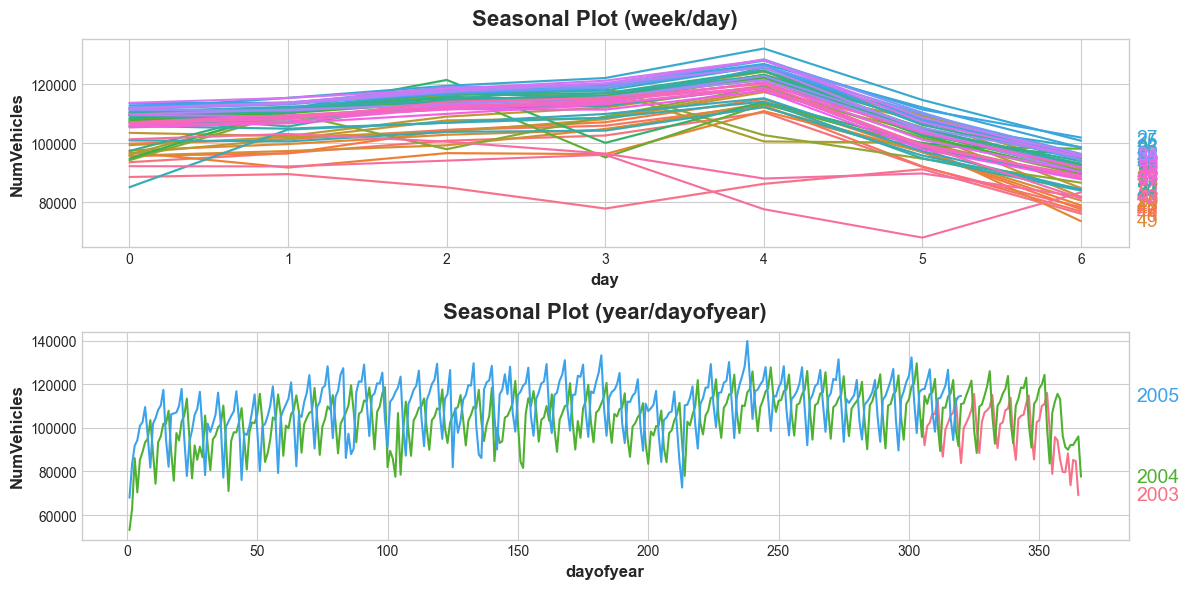

In [10]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,6))
seasonal_plot(X, y='NumVehicles', period='week', freq='day', ax=ax0)
seasonal_plot(X, y='NumVehicles', period='year', freq='dayofyear', ax=ax1)

# periodogram 週期圖法
計算譜密度

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

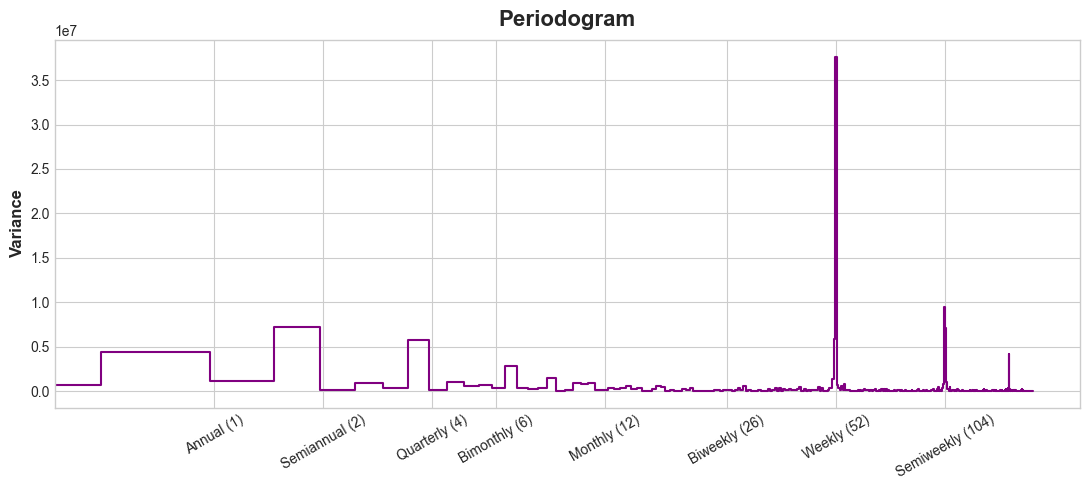

In [11]:
plot_periodogram(tunnel.NumVehicles)

In [12]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq='A', order=10)

dp = DeterministicProcess(
    index=tunnel.index, 
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


In [17]:
X.shape

(747, 28)

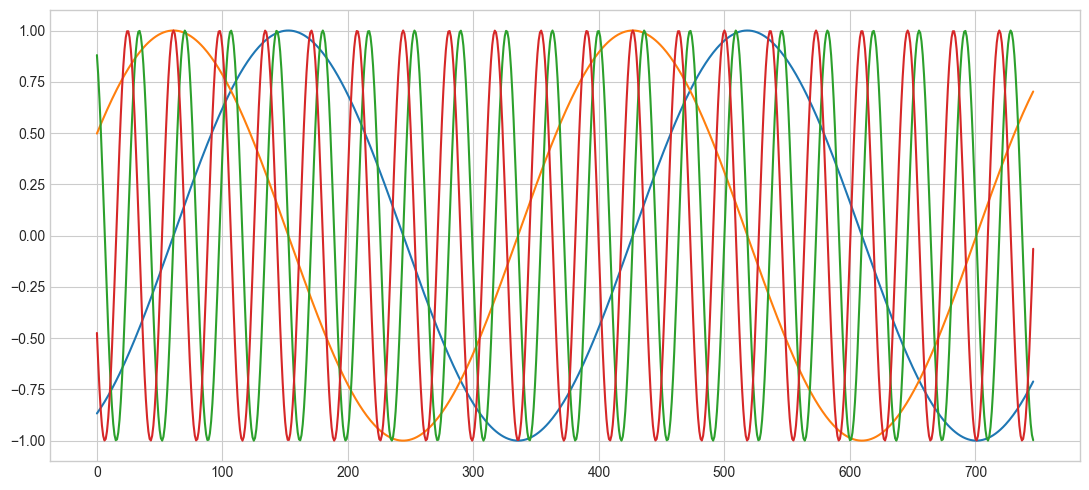

In [29]:
plt.plot(X['sin(1,freq=A-DEC)'].values)
plt.plot(X['cos(1,freq=A-DEC)'].values)
plt.plot(X['sin(10,freq=A-DEC)'].values)
plt.plot(X['cos(10,freq=A-DEC)'].values)

In [14]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [15]:
y_pred_ = model.predict(X)
y_pred = pd.Series(y_pred_, index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore_ = model.predict(X_fore)
y_fore = pd.Series(y_fore_, index=X_fore.index)

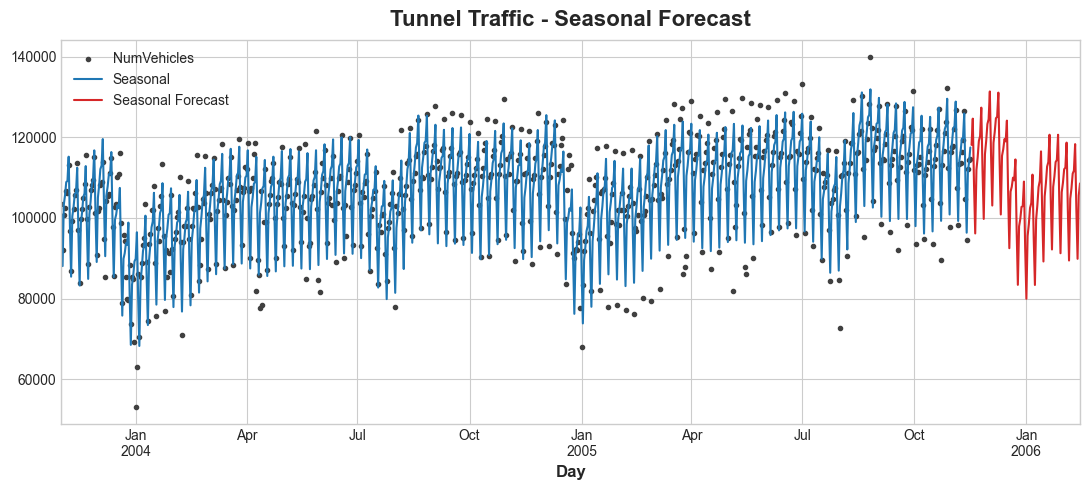

In [16]:
ax = y.plot(color='0.25', style='.', title='Tunnel Traffic - Seasonal Forecast')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax = y_fore.plot(ax=ax, label='Seasonal Forecast', color='C3')
ax.legend()